# Fragment Analyser demo

FragmentAnalyser (jan 2016) is not a python package; 
so you need to use the executable called **fragment_analyser**.

To install it, type::
        
        git clone https://github.com/cokelaer/FragmentAnalyser.git
        cd FragmentAnalyser
        python setup.py install
        
You would need the following dependencies::
        
        pandas
        numpy
        matplotlib


### Motivation

Examples are in ./test or in ./data




In [1]:
from IPython.display import Image
%pylab  inline

Populating the interactive namespace from numpy and matplotlib


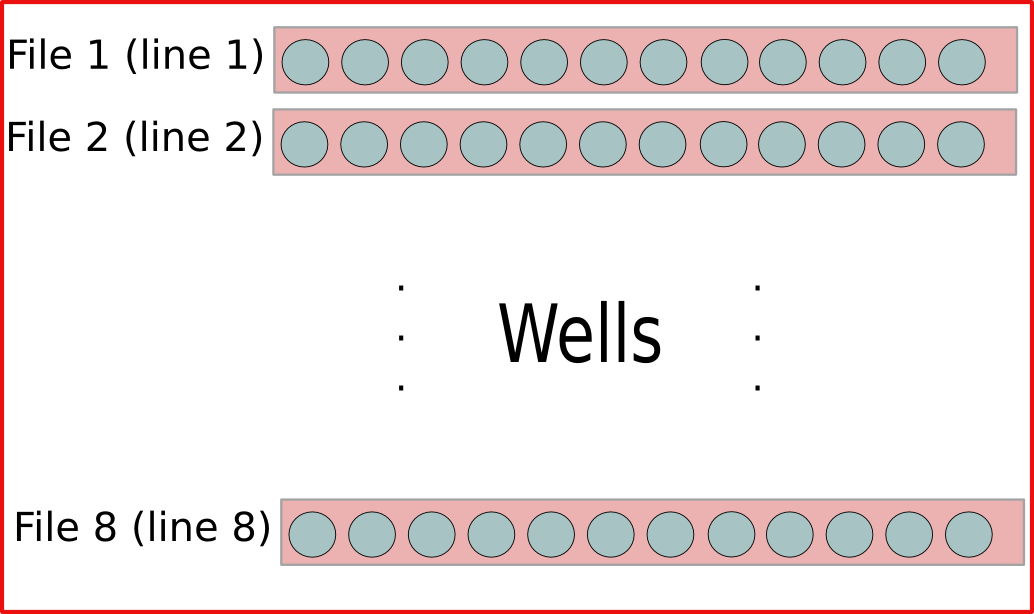

In [4]:
# In principle, we should have 8 CSV files for a given plate. Each file 
# contains data for 12 wells.
# For each well, we have a PDF file showing the spetrum and set of peaks 
# that were identified and saved in the CSV file.
Image('../doc/plate.png', width=800, height=400)

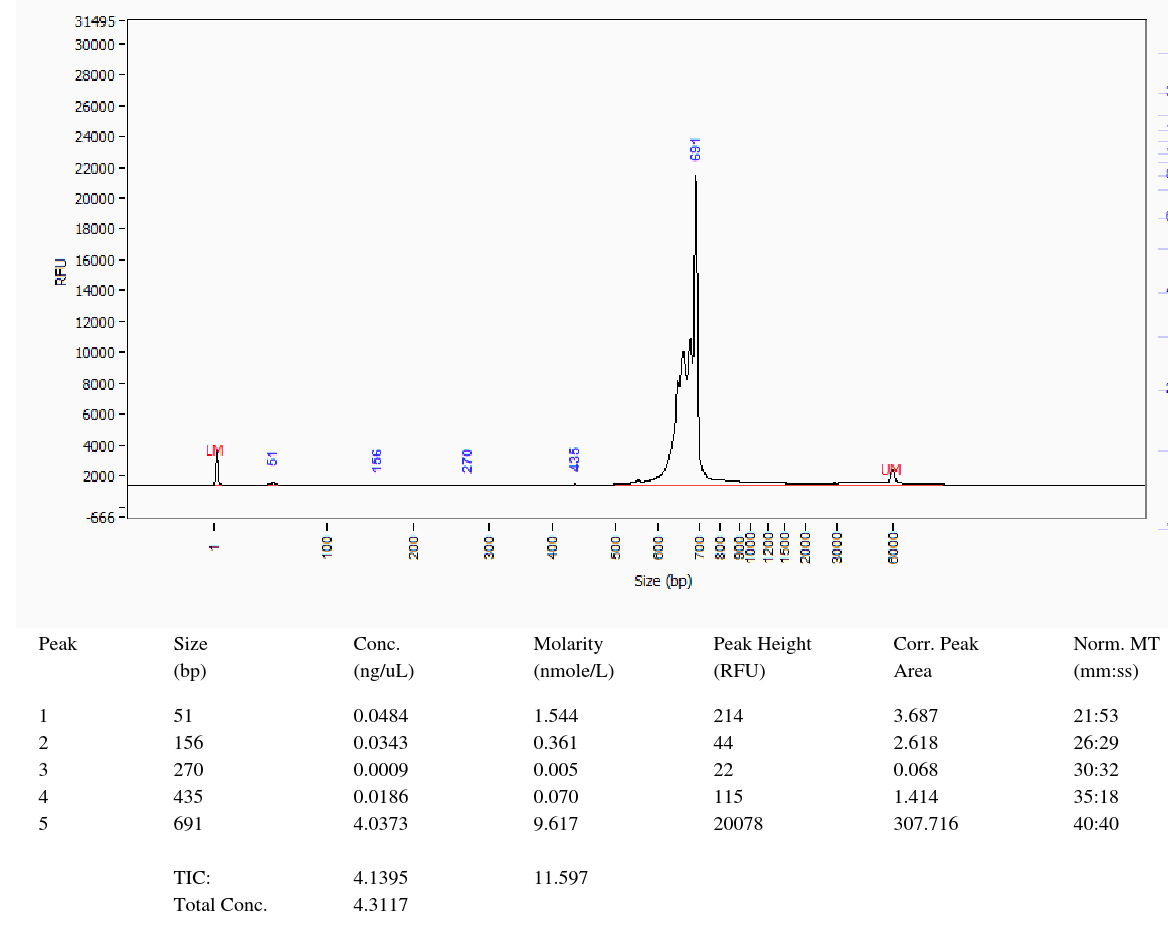

In [5]:
# Here is an example for 1 file (i.e., 1 well)
Image('../doc/raw_data_example.png', width=800, height=400)

The data in the table are stored in one CSV file together with the other 11 wells

In [7]:
import pandas as pd
data = pd.read_csv('../share/data/example_format_unstructured.csv')
data.ix[0:10]

,A1,BJ,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Peak ID,Size (bp),% (Conc.),nmole/L,ng/ul,RFU,Avg. Size
1,1,1 (LM),NaN,21.475,0.0164,1740,1
2,2,65,26.4,2.220,0.0875,842,67
3,3,168,62.0,2.007,0.2055,541,162
4,4,608,11.6,0.104,0.0384,100,610
5,5,6000 (UM),NaN,0.001,0.0035,594,6012
6,,,,NaN,NaN,NaN,NaN
7,,TIC:,0.3314,ng/uL,NaN,NaN,NaN
8,,TIM:,4.331,nmole/L,NaN,NaN,NaN
9,,Total Conc.:,0.6760,ng/uL,NaN,NaN,NaN


This is a structured CSV file that summarises the peaks found in 12 wells. 

One need to extract the sub data for each well. Then, to get relevant peak (size bp). One way is to identify the maximum RFU and corresponding peak. To check that it makes sense (bp size in 400-700 range) and finally to use the corresponding concentration (column 3) and report it in a CSV file. This needs to be be done for the 12 wells and repeated across 8 files. This is obviously a source off errors. This was the motivation to create FragmentAnalyser.


### PeakTableReader class

This class reads one file, which correspond to one line (12 wells) ?

Note that the 12th wells is just a control and is ignored

In [9]:
import fragment_analyser

/home/cokelaer/Work/virtualenv/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [11]:
# read an example
ptr = fragment_analyser.PeakTableReader('../share/data/example_format_unstructured.csv')

Alternate input data


In [12]:
# The 12 wells are here
ptr.wells

In [13]:
# You can check the data that was extracted for that well
well = ptr.wells[0]
well.df

,Peak ID,Size (bp),% (Conc.),nmole/L,ng/ul,RFU,Avg. Size,TIC (ng/uL),TIM (nmole/L),Total Conc.: (ng/uL)
1,2,65,26.4,2.220,0.0875,842,67,0.3314,4.331,0.676
2,3,168,62.0,2.007,0.2055,541,162,0.3314,4.331,0.676
3,4,608,11.6,0.104,0.0384,100,610,0.3314,4.331,0.676


In [14]:
# This well has 3 peaks.  
# Internally, a lower bp sise threashold is set (120 by default) so the first peak (65) even
# though has the highest RFU would be discarded. The second peak has the highest RFU and kept. 
# Yet, we know this is not our peak that is around 600.
well.get_peak()

168.0

In [15]:
#Identifying a peak based on a single well is not robust given the small data
# set. Instead we look at the level of a line
line = ptr.get_line()

In [16]:
peaks = line.get_peaks()
peaks

[168.0, 584.0, 164.0, 1261.0, 168.0, 172.0, 608.0, 164.0, 575.0, 583.0, 609.0]

In [17]:
assert peaks == [168.0, 584.0, 164.0, 1261.0, 168.0, 172.0, 608.0, 164.0, 575.0, 583.0, 609.0]

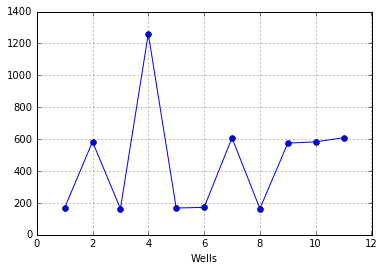

In [18]:
plot(range(1,12), peaks, 'o-');
grid()
xlabel('Wells')

Here is a difficult case where an expected peak at RFU=600 is  found in 5 wells only. 5 other wells have a strong peak around 180 and one well has  a strong peak at RFU=1200.

The lower bound threshold is 120. If we set it to 200, we would identify the peaks in 10 out of 11 wells. But what if there is noise around RFU=220 in  another experiment ?


Another solution (naively taking the max RFU and reporting the corresponding bp value) is required. Based on the 11 wells.


So, we will weight down the outliers. We first need to estimate the peak position. This can be done automatically with a median estimate or as an input from the user. 

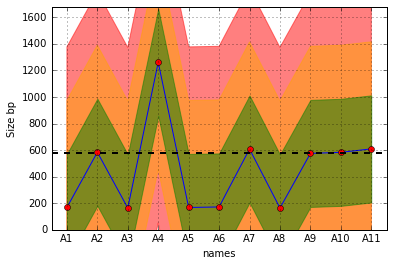

In [19]:
# shows naive peak detection based on max over RFU
line.diagnostic()

In [20]:
# Since real peaks are expected around 600, we could provide 
# this guess as an information but otherwise, based solely 
# on a median estimate, this function should work out of the 
# box
line.guess_peak()

575.0

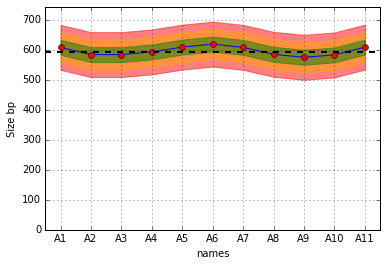

In [21]:
# This will be used internally to call set_guess later one, which
# puts weights on outlier
line.set_guess(); line.diagnostic()

**About the confidence areas**
    
We could compute the mean and variance and assuming a gaussian distribution set a threshodl to e.g. 3 sigmas but there are two issues.

- few data point
- is this gaussian
- outliers are present and variance is squared so deep impact

Instead, we will compute the MAD (median absoulte deviation):

    MAD = median(| peaks - median(peaks)|)
    
- If a peak + 3 MAD < median(peaks) we drop the peak
- If a peak - 3 MAD > median(peaks) we drop the peak
- Otherwise, we keep

The Line class only provides information about the wells/peaks. The actual computation is performed in 
the Plate class

### Working at a plate level

In [22]:
filenames = ['../share/data/Laurence/lineA.csv', 
            '../share/data/Laurence/lineB.csv',
            '../share/data/Laurence/lineC.csv']
plate = fragment_analyser.PlatePFGE(filenames)

Reading the 3 files:
 - ../share/data/Laurence/lineA.csv Alternate input data
...done
 - ../share/data/Laurence/lineB.csv Alternate input data
...done
 - ../share/data/Laurence/lineC.csv Alternate input data
...done


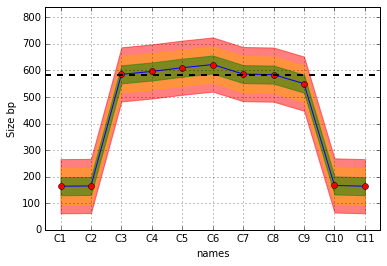

In [23]:
# This plate has nothing in wells 1, 2, 10, 11
plate.lines[2].diagnostic()

Data that are away from the median estimate will be discarded (set to NA)

In [24]:
plate.to_csv('summary.csv')

In [25]:
pd.read_csv('summary.csv')

,names,ng/uL (QUBIT/FA),Size (bp),nM
0,BJ,0.0384,608,0.097166
1,BK,0.3997,584,1.052950
2,CV,0.1212,584,0.319283
3,CW,0.1386,593,0.359580
4,CX,0.0562,609,0.141973
5,CZ,0.0479,619,0.119051
6,DA,0.0953,608,0.241144
7,DB,0.0322,585,0.084681
8,DC,0.2087,575,0.558395
9,DD,0.2728,583,0.719884


In [26]:
plate.lines[0].wells[0].get_peak()

608.0